In [1]:
import os 
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas() 
from datetime import datetime, timedelta
from collections import Counter
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import seaborn as sns
from scipy.stats import norm
warnings.filterwarnings("ignore")

In [2]:
os.chdir('./ddps')
# original dataset
data=pd.read_pickle("data_transformed_cleaned.pkl")

**Session duration**

In [3]:
# duration
def process_user_data(df):
    processed = []
    df=df.sort_values(by=['timestamp_converted'])
    # iterate over rows
    for index, row in df.iterrows():
        if processed:
            last_activity = processed[-1] # create a reference to the dictionary last activity to update it 
            #  time difference 
            time_diff = (row['timestamp_converted'] - last_activity['end_time']).total_seconds() / 60
            # Check if the current activity is the same type and within 10 minutes 
            if last_activity['activity_type'] == row['activity_type'] and time_diff <= 10:
                # Extend the current activity duration by updating the end_time to the latest one
                last_activity['end_time'] = row['timestamp_converted']
            else:
                # calculate duration for the last activity
                last_activity['duration'] = (last_activity['end_time'] - last_activity['start_time']).total_seconds() / 60
                
                # a new activity type or more than 10 mins have passed since the last activity
                new_activity = row.to_dict()
                new_activity['start_time'] = row['timestamp_converted']
                new_activity['end_time'] = row['timestamp_converted']
                processed.append(new_activity)
        else:
            # empty, add the first row with initial start and end times
            new_activity = row.to_dict()
            new_activity['start_time'] = row['timestamp_converted']
            new_activity['end_time'] = row['timestamp_converted']
            processed.append(new_activity)

    # duration for the last activity in the list after the loop
    if processed:
        last_activity = processed[-1]
        last_activity['duration'] = (last_activity['end_time'] - last_activity['start_time']).total_seconds() / 60

    return pd.DataFrame(processed)




In [4]:
grouped = data.sort_values(by=['timestamp_converted']).groupby(['user_id'])
data_duration=pd.concat([process_user_data(group) for _, group in grouped])


In [11]:
#data_duration=data_duration[data_duration.duration!=0]

### HMM models 

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from hmmlearn import hmm
import numpy as np

df_filter1=[
 'likes_and_follows',
 'posts',
 'reactions',
 'last_seen_content',
 'searches',
 'search_history',
 'saved_posts',
 'comment_history',
 'shared_links',
 'likes',
 'favorite_videos_effects_hashtags_sounds',
 'shared_videos',
 'search_history',
 'watched_videos',
 'search_history',
 'watch_history']
# Load your data
data = data_duration[data_duration.activity_type.isin(df_filter1)]# Adjust the filename as needed



In [8]:
# Combine platform and activity into a single observable symbol
data['symbol'] = data['platform'] + ':' + data['activity_type']

# Encode the symbols
encoder = LabelEncoder()
data['encoded_symbols'] = encoder.fit_transform(data['symbol'])

# Check the encoded data
print(data[['symbol', 'encoded_symbols']].head())



               symbol  encoded_symbols
0  facebook:reactions                3
1  facebook:reactions                3
2  facebook:reactions                3
3  facebook:reactions                3
4  facebook:reactions                3


In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp_converted'])

# Extract date (ignoring time) from the timestamp
data['date'] = data['timestamp'].dt.date

# Assign day modifiers by grouping by 'case_id' and ranking by the 'date'
data['day_modifier'] = data.groupby('user_id')['date'].rank(method='dense').astype(int)

# Combine 'case_id' and the day modifier to create the new 'case_id_day' column
data['case_id_day'] = data['user_id'].astype(str) + '_day' + data['day_modifier'].astype(str)


In [10]:
# for multi platform users 
df_new1=data.groupby(["platform", "user_id"]).size().reset_index()
df_plat=df_new1.groupby("user_id").count().reset_index()
df_plat.groupby("platform").count().reset_index()
users=df_plat[df_plat.platform>2].user_id.to_list()
data_new=data[data.user_id.isin(users)]


In [11]:
# Sort data by user_id and timestamp
data_sorted = data_new.sort_values(by=['case_id_day', 'timestamp'])

# Group data by user_id and collect activity codes
grouped = data_sorted.groupby('case_id_day')['encoded_symbols'].apply(list)

# Convert grouped object into a list of arrays
sequences = [np.array(seq).reshape(-1, 1) for seq in grouped]
lengths = [len(seq) for seq in sequences]

# Print sample data
print("Sample Sequence (Encoded):", sequences[0])
print("Sequence Lengths:", lengths[:5])


Sample Sequence (Encoded): [[12]
 [12]
 [13]
 [13]
 [13]
 [ 2]
 [ 4]
 [ 0]]
Sequence Lengths: [8, 6, 1, 2, 3]


In [12]:
# Check the distribution of sequence lengths
print(pd.Series(lengths).describe())


count    2847.000000
mean       21.463646
std        36.446661
min         1.000000
25%         5.000000
50%        11.000000
75%        24.000000
max       646.000000
dtype: float64


In [13]:
np.quantile([i for i in lengths], q=[0.25, 0.75, 0.9])

array([ 5. , 24. , 50.4])

In [14]:
# Filter sequences to remove very short ones
min_length = 5
filtered_sequences = [seq for seq in sequences if len(seq) >= min_length and len(seq) < 50]
filtered_lengths = [len(seq) for seq in filtered_sequences]

if not filtered_sequences:
    print("No sequences long enough to model!")

In [16]:
# Initialize Multinomial HMM
model = hmm.CategoricalHMM(n_components=4, n_iter=100, random_state=42, init_params='ste')

In [17]:
# Fit the HMM to the data
model.fit(np.concatenate(filtered_sequences), lengths=filtered_lengths)

CategoricalHMM(n_components=4, n_features=16, n_iter=100,
               random_state=RandomState(MT19937) at 0x7F41E0555E20)

In [ ]:
### find the optimal number of states 
aic = []
bic = []
lls = []
ns = [2, 3, 4, 5]
models=[]
for n in tqdm(ns):
    best_ll = None
    best_model = None
    for i in range(10):
        h = hmm.CategoricalHMM(n_components=n, n_iter=100, random_state=42, init_params='ste')
        h.fit(np.concatenate(filtered_sequences))
        score = h.score(np.concatenate(filtered_sequences))
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = h
    aic.append(best_model.aic(np.concatenate(filtered_sequences)))
    bic.append(best_model.bic(np.concatenate(filtered_sequences)))
    lls.append(best_model.score(np.concatenate(filtered_sequences)))
    models.append(best_model)

  0%|          | 0/4 [00:00<?, ?it/s]

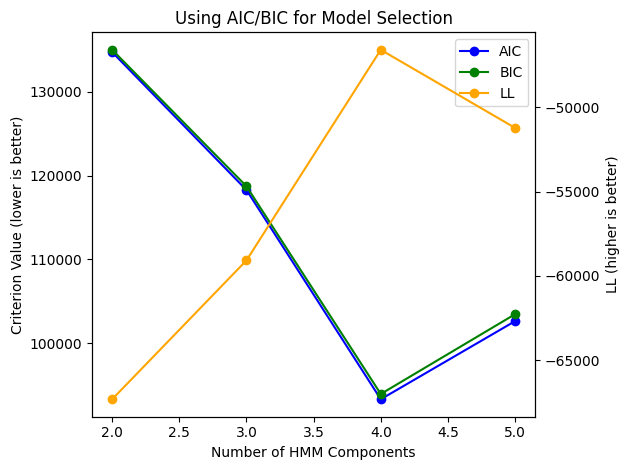

In [21]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

In [23]:
print("Learned transition matrix:")
print(models[2].transmat_)

Learned transition matrix:
[[0.9372298  0.03375256 0.01284758 0.01617006]
 [0.0493355  0.88361513 0.03643551 0.03061387]
 [0.01457667 0.03571936 0.92764366 0.0220603 ]
 [0.02848332 0.03437532 0.0273759  0.90976546]]


In [24]:
df=pd.DataFrame(models[2].transmat_, columns=["State 0", "State1", "State 2", "State 3"])
df.index=["State 0", "State 1", "State 2", "State 3"]

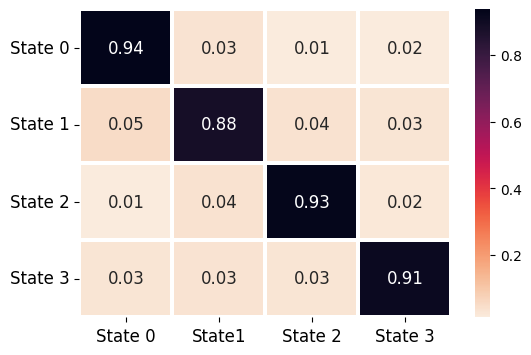

In [33]:
import seaborn as sns
import matplotlib
fig, ax=plt.subplots(figsize=(6,4
                            )) 
g=sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,  fmt=".2f", annot_kws={"fontsize":12}, cmap= matplotlib.cm.get_cmap('rocket_r'),linewidths=1.5)
g.set_yticklabels(g.get_yticklabels(), rotation =0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../hmm1.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
models[2].monitor_.converged

True

In [27]:
 models[2].startprob_

array([1.00000000e+000, 0.00000000e+000, 8.84704955e-100, 0.00000000e+000])

In [29]:
# Extract emission probabilities
emissions = models[2].emissionprob_
emi_dict={}
# Print emission probabilities for each hidden state
for index, emission in enumerate(emissions):
    print(f"Emission probabilities for hidden state {index}:")
    ls_dict={}
    for symbol_idx, prob in enumerate(emission):
        symbol = encoder.inverse_transform([symbol_idx])[0]
        print(f"  {symbol}: {prob:.4f}")
        ls_dict[symbol]=prob
    emi_dict[index]=ls_dict
        
    print("\n")


Emission probabilities for hidden state 0:
  facebook:last_seen_content: 0.0080
  facebook:likes_and_follows: 0.0002
  facebook:posts: 0.0002
  facebook:reactions: 0.0012
  facebook:searches: 0.0102
  instagram:comment_history: 0.0003
  instagram:likes: 0.0192
  instagram:saved_posts: 0.0001
  instagram:search_history: 0.0001
  instagram:shared_links: 0.0075
  tiktok:favorite_videos_effects_hashtags_sounds: 0.0554
  tiktok:search_history: 0.1544
  tiktok:shared_videos: 0.0497
  tiktok:watched_videos: 0.6839
  youtube:search_history: 0.0008
  youtube:watch_history: 0.0087


Emission probabilities for hidden state 1:
  facebook:last_seen_content: 0.0096
  facebook:likes_and_follows: 0.0009
  facebook:posts: 0.0024
  facebook:reactions: 0.0012
  facebook:searches: 0.0185
  instagram:comment_history: 0.0146
  instagram:likes: 0.5007
  instagram:saved_posts: 0.0272
  instagram:search_history: 0.0023
  instagram:shared_links: 0.3851
  tiktok:favorite_videos_effects_hashtags_sounds: 0.0000
  

In [31]:
def italic(str):
    return f'$\it{str}$'

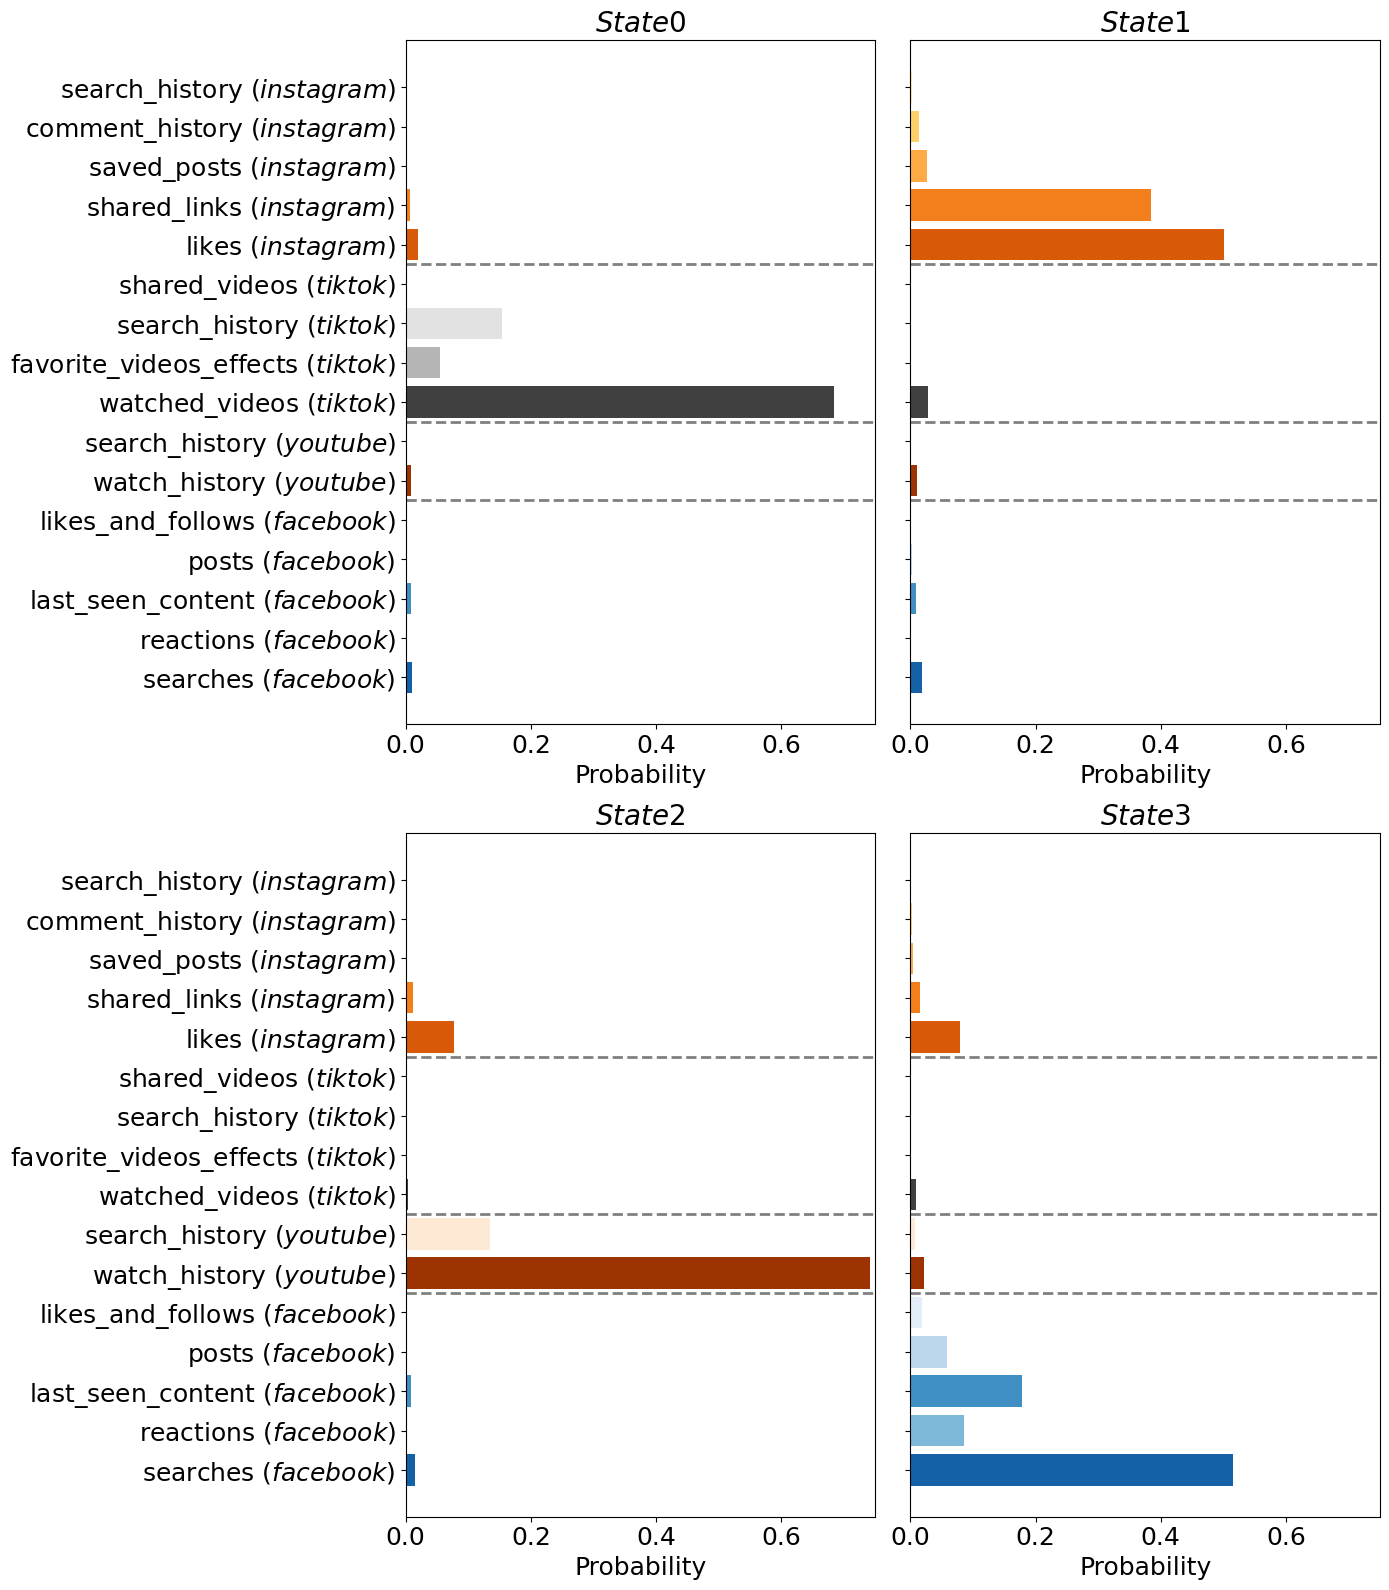

In [34]:
### plot emission probability 
# Define custom colors
custom_colors = {
    "facebook:searches": "#1461A8",
    "facebook:reactions": "#7DB8D9",
    "facebook:last_seen_content": "#3F8FC4",
    "facebook:posts": "#BCD7EB",
    "facebook:likes_and_follows": "#E3EEF8",
    "youtube:watch_history": "#9D3203",
    "youtube:search_history": "#FEE9D4",
    "tiktok:watched_videos": "#404040",
    "tiktok:favorite_videos_effects_hashtags_sounds": "#B5B5B5",
    "tiktok:search_history": "#E2E2E2",
    "tiktok:shared_videos": "#FFFFFF",
    "instagram:likes": "#D85908",
    "instagram:shared_links": "#F27F1C",
    "instagram:saved_posts": "#feab46",
    "instagram:comment_history": "#FED069",
    "instagram:search_history": "#FEEBA2"
}

# Create figure and axes for a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 16), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for i, (state, probabilities) in enumerate(emi_dict.items()):
    activities = sorted(probabilities.keys(), key=lambda x: list(custom_colors.keys()).index(x))
    values = [probabilities[activity] for activity in activities if activity in probabilities]
    colors = [custom_colors[activity] for activity in activities if activity in probabilities]
    platforms = [activity.split(':')[0] for activity in activities]
    simplified_activities = ["_".join(activity.split(':')[1].split("_")[:3]) for activity in activities] 
    new_activity = [f'{activity} ({italic(platforms[i])})' for i, activity in enumerate(simplified_activities)]
    
    axes[i].barh(new_activity, values, color=colors)
    string=f'State  {str(state)}'
    axes[i].set_title(italic(string), fontsize=20)
    axes[i].set_xlim(0, 0.75)
    axes[i].invert_yaxis()
    axes[i].set_xlabel('Probability', fontsize=18)
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='both', which='major', labelsize=18)
    for index in [5, 7, 11]:
        axes[i].axhline(y=index - 0.5, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.savefig('../hmm2.png', dpi=300, bbox_inches='tight')
plt.show()